### Extracting the text from the file

In [20]:
file=open("/content/Brown_train.txt")
Text=file.readlines()
Vocab=set()
TagSet=set()

In [21]:
Sentences=[]
index=0
while (index < len(Text)):
    TempSentence=Text[index].replace("\n","")    
    j=TempSentence.split(" ")
    TempWordTag=[]
    for pair in j:
        
        TempWordTag.append(pair.split("_"))

# These are the sentences which were uncorrectly splitted into two sentences on 's.
# We could have ignored them as mentioned in the comments
# but since these are valid sentences I combine them together.
    if(len(TempWordTag[-1])==1 and index!=len(Text)-1):
#         print(index)
#         print(Text[index],Text[index+1])
        TempSentence=Text[index].replace("\n","") + Text[index+1].replace("\n","") 
        index+=1
        j=TempSentence.split(" ")
        TempWordTag=[]
        for pair in j:
            TempWordTag.append(pair.split("_"))
        
    Sentences.append(TempWordTag)
    index+=1

In [22]:
count=0
PossibleTagsOfWord={}
for i in Sentences:
    count+=1
    for j in i:
        if(len(j)==2):
            TagSet.add(j[1])
            Vocab.add(j[0])
            pair=j
            if(pair[0] in PossibleTagsOfWord):
                    PossibleTagsOfWord[pair[0]].add(pair[1])
            else:
                    PossibleTagsOfWord[pair[0]]=set()
                    PossibleTagsOfWord[pair[0]].add(pair[1])


In [23]:
# Emission probabilities
def EmissionProbability(TrainSet):
    EmissionCount={}
    CountWordsOfTag={"^":0}
    for Sentence in TrainSet:
        CountWordsOfTag["^"]+=1
        for pair in Sentence:
            if(len(pair)==2):
                if(pair[1] in CountWordsOfTag):
                    CountWordsOfTag[pair[1]]+=1
                else:
                    CountWordsOfTag[pair[1]]=1
                temp=(pair[0]+"_"+pair[1])
                if( temp in EmissionCount):
                    EmissionCount[temp]+=1
                else:
                    EmissionCount[temp]=1
    return(EmissionCount,CountWordsOfTag)

In [24]:
def TransitionProbability(TrainSet):
    TagPairCount={}
    for Sentence in TrainSet:
        index=0
        if(len(Sentence[index])==2):
            temp="^_"+Sentence[index][1]
            if(temp in TagPairCount):
                TagPairCount[temp]+=1
            else:
                TagPairCount[temp]=1
        while(index<len(Sentence)-1):
            if(len(Sentence[index])==2 and len(Sentence[index+1])==2):
                temp=Sentence[index][1]+"_"+Sentence[index+1][1]
                if(temp in TagPairCount):
                    TagPairCount[temp]+=1
                else:
                    TagPairCount[temp]=1
            index+=1
    return(TagPairCount)

In [25]:
def TrigramsCount(TrainSet):
    TagTripletCount={}
    for Sentence in TrainSet:
        index=0
        if(len(Sentence[index])==2):
            temp="^_^_"+Sentence[index][1]
            if(temp in TagTripletCount):
                TagTripletCount[temp]+=1
            else:
                TagTripletCount[temp]=1
        if(index+1 < len(Sentence) and len(Sentence[index+1])==2):
            temp="^_"+Sentence[index][1]+"_"+Sentence[index+1][1]
            if(temp in TagTripletCount):
                TagTripletCount[temp]+=1
            else:
                TagTripletCount[temp]=1

        while(index<len(Sentence)-2):
            if(len(Sentence[index])==2 and len(Sentence[index+1])==2 and len(Sentence[index+2])==2):
                temp=Sentence[index][1]+"_"+Sentence[index+1][1]+"_"+Sentence[index+2][1]
                if(temp in TagTripletCount):
                    TagTripletCount[temp]+=1
                else:
                    TagTripletCount[temp]=1
            index+=1
    return(TagTripletCount)

In [26]:
from math import log
def Viterbi4(Sentence):
    V=len(Vocab)
    T=len(TagSet)
    TrainTagSet=CountWordsOfTag.keys()
    ViterbiSeq={}
    ViterbiProbab={}
    State_PrevTag={}
    State_PrevTag[1]=set()
    word=Sentence[0]
    if word in PossibleTagsOfWord:
        for tag in PossibleTagsOfWord[word]:
            EmissionProbab=(EProbab[word+"_"+tag])
            TransitionProbab=(TProbab["^_"+tag])
            CurrentProbab=EmissionProbab*TransitionProbab
            ViterbiProbab[(1,tag)]=log(CurrentProbab)
            ViterbiSeq[(1,tag)]=[tag]
            State_PrevTag[1].add(tag)
    else:
        for tag in TagSet:
            EmissionProbab=(EProbab[word+"_"+tag])
            TransitionProbab=(TProbab["^_"+tag])
            CurrentProbab=EmissionProbab*TransitionProbab
            ViterbiProbab[(1,tag)]=log(CurrentProbab)
            ViterbiSeq[(1,tag)]=[tag]
            State_PrevTag[1].add(tag)
            
        
    count=1
    for i in Sentence[1:]:
        count+=1
        CurrentWord=i
        State_PrevTag[count]=set()
        if CurrentWord in PossibleTagsOfWord:
            for tag in PossibleTagsOfWord[CurrentWord]:
                EmissionProbab=EProbab[CurrentWord+"_"+tag]
                for prevtag in State_PrevTag[count-1]:
                    TransitionProbab=TProbab[prevtag+"_"+tag]
                    CurrentProbab=log(EmissionProbab*TransitionProbab) + ViterbiProbab[(count-1,prevtag)]
                    if((count,tag) in ViterbiProbab and CurrentProbab>=ViterbiProbab[(count,tag)]):
                        ViterbiProbab[(count,tag)]=CurrentProbab
                        ViterbiSeq[(count,tag)]=ViterbiSeq[(count-1,prevtag)]+[tag]
                    elif((count,tag) not in ViterbiProbab):
                        ViterbiProbab[(count,tag)]=CurrentProbab
                        ViterbiSeq[(count,tag)]=ViterbiSeq[(count-1,prevtag)]+[tag]
                        State_PrevTag[count].add(tag)
        else:
            for tag in TagSet:
                EmissionProbab=EProbab[CurrentWord+"_"+tag]
                for prevtag in State_PrevTag[count-1]:
                    TransitionProbab=TProbab[prevtag+"_"+tag]
                    CurrentProbab=log(EmissionProbab*TransitionProbab) + ViterbiProbab[(count-1,prevtag)]
                    if((count,tag) in ViterbiProbab and CurrentProbab>=ViterbiProbab[(count,tag)]):
                        ViterbiProbab[(count,tag)]=CurrentProbab
                        ViterbiSeq[(count,tag)]=ViterbiSeq[(count-1,prevtag)]+[tag]
                    elif((count,tag) not in ViterbiProbab):
                        ViterbiProbab[(count,tag)]=CurrentProbab
                        ViterbiSeq[(count,tag)]=ViterbiSeq[(count-1,prevtag)]+[tag]
                        State_PrevTag[count].add(tag)
            
    MaxProbab=-float('inf')
    BestSeq=[]
#     for i in range(count,1,-1):
# #         print(i,len(State_PrevTag[i]))
#         templis=[]
#         for j in State_PrevTag[i]:
# #             print(j)
#             templis.append([ViterbiProbab[(i,j)],ViterbiSeq[(i,j)],j])
# #             print(len(ViterbiSeq[(i,j)]),ViterbiProbab[(i,j)])
#         templis.sort(reverse=True)
# #         print(len(templis),i)
#         for z in range(len(templis)):
#                 print(i,templis[z])
    for i in State_PrevTag[count]:
        p=ViterbiProbab[(count,i)]
        if(MaxProbab<p):
            BestSeq=ViterbiSeq[(count,i)]
            MaxProbab=p
    return(BestSeq)




In [27]:
from math import log
def Viterbi3(Sentence):
    V=len(Vocab)
    T=len(TagSet)
    TrainTagSet=CountWordsOfTag.keys()
    ViterbiSeq={}
    ViterbiProbab={}
    State_PrevTag={}
    State_PrevTag[1]=set()
    word=Sentence[0]
    for tag in TagSet:
        EmissionProbab=(EProbab[word+"_"+tag])
        TransitionProbab=(TProbab["^_"+tag])
        CurrentProbab=log(EmissionProbab*TransitionProbab)
        if(CurrentProbab!=0):
            ViterbiProbab[(1,tag)]=CurrentProbab
            ViterbiSeq[(1,tag)]=[tag]
            State_PrevTag[1].add(tag)
    
    count=1
    for i in Sentence[1:]:
        count+=1
        CurrentWord=i
        State_PrevTag[count]=set()
        for tag in TagSet:
            EmissionProbab=EProbab[CurrentWord+"_"+tag]
            for prevtag in State_PrevTag[count-1]:
                TransitionProbab=TProbab[prevtag+"_"+tag]
                CurrentProbab=log(EmissionProbab*TransitionProbab)+ViterbiProbab[(count-1,prevtag)]
                if((count,tag) in ViterbiProbab and CurrentProbab>=ViterbiProbab[(count,tag)]):
                    ViterbiProbab[(count,tag)]=CurrentProbab
                    ViterbiSeq[(count,tag)]=ViterbiSeq[(count-1,prevtag)]+[tag]
                elif((count,tag) not in ViterbiProbab):
                    ViterbiProbab[(count,tag)]=CurrentProbab
                    ViterbiSeq[(count,tag)]=ViterbiSeq[(count-1,prevtag)]+[tag]
                    State_PrevTag[count].add(tag)
    MaxProbab=-float('inf')
    BestSeq=[]
#     for i in range(count,1,-1):
# #         print(i,len(State_PrevTag[i]))
#         templis=[]
#         for j in State_PrevTag[i]:
# #             print(j)
#             templis.append([ViterbiProbab[(i,j)],ViterbiSeq[(i,j)],j])
# #             print(len(ViterbiSeq[(i,j)]),ViterbiProbab[(i,j)])
#         templis.sort(reverse=True)
# #         print(len(templis),i)
#         for z in range(len(templis)):
#                 print(i,templis[z])
    for i in State_PrevTag[count]:
        p=ViterbiProbab[(count,i)]
        if(MaxProbab<p):
            BestSeq=ViterbiSeq[(count,i)]
            MaxProbab=p
    return(BestSeq)


#     print(ViterbiSeq)
#     print(ViterbiProbab)

In [29]:
def TrigramsViterbi(Sentence):
    V=len(Vocab)
    T=len(TagSet)
    ViterbiSeq={}
    ViterbiProbab={}
    State_PrevTag={}
    State_PrevTag[1]=set()
    word=Sentence[0]
    if word in PossibleTagsOfWord:
        for tag in PossibleTagsOfWord[word]:
            EmissionProbab=(EProbab[word+"_"+tag])
            TransitionProbab=(TProbab["^_"+tag])
            CurrentProbab=log(EmissionProbab*TransitionProbab)
            ViterbiProbab[(1,"^_"+tag)]=CurrentProbab
            ViterbiSeq[(1,"^_"+tag)]=[tag]
            State_PrevTag[1].add("^_"+tag)
    else:
        for tag in TagSet:
            EmissionProbab=(EProbab[word+"_"+tag])
            TransitionProbab=(TProbab["^_"+tag])
            CurrentProbab=log(EmissionProbab*TransitionProbab)
            ViterbiProbab[(1,"^_"+tag)]=CurrentProbab
            ViterbiSeq[(1,"^_"+tag)]=[tag]
            State_PrevTag[1].add("^_"+tag)
        
    count=1
    for i in Sentence[1:]:
        count+=1
        CurrentWord=i
        State_PrevTag[count]=set()
        if CurrentWord in PossibleTagsOfWord:            
            for tag in PossibleTagsOfWord[CurrentWord]:
                EmissionProbab=EProbab[CurrentWord+"_"+tag]
                for prevtag in State_PrevTag[count-1]:
                    if(prevtag in TagPairCount):
                        if(prevtag+"_"+tag in TagTripletCount):
                            TransitionProbab=(TagTripletCount[prevtag+"_"+tag]+1)/(TagPairCount[prevtag]+T)
                        else:
                            TransitionProbab=(1)/(TagPairCount[prevtag]+T)
                    else:
                        TransitionProbab=(1)/(T)
                    CurrentProbab=log(EmissionProbab*TransitionProbab)+ViterbiProbab[(count-1,prevtag)]
                    newtag=prevtag.split("_")[1]+"_"+tag
                    if((count,newtag) in ViterbiProbab and CurrentProbab>=ViterbiProbab[(count,newtag)]):
                        ViterbiProbab[(count,newtag)]=CurrentProbab
                    elif((count,newtag) not in ViterbiProbab):
                        ViterbiProbab[(count,newtag)]=CurrentProbab
                        ViterbiSeq[(count,newtag)]=ViterbiSeq[(count-1,prevtag)]+[tag]
                    State_PrevTag[count].add(newtag)

        else:
            for tag in TagSet:
                EmissionProbab=EProbab[CurrentWord+"_"+tag]
                for prevtag in State_PrevTag[count-1]:
                    if(prevtag in TagPairCount):
                        if(prevtag+"_"+tag in TagTripletCount):
                            TransitionProbab=(TagTripletCount[prevtag+"_"+tag]+1)/(TagPairCount[prevtag]+T)
                        else:
                            TransitionProbab=(1)/(TagPairCount[prevtag]+T)
                    else:
                        TransitionProbab=(1)/(T)
                    CurrentProbab=log(EmissionProbab*TransitionProbab)+ViterbiProbab[(count-1,prevtag)]
                    newtag=prevtag.split("_")[1]+"_"+tag
                    if((count,newtag) in ViterbiProbab and CurrentProbab>=ViterbiProbab[(count,newtag)]):
                        ViterbiProbab[(count,newtag)]=CurrentProbab
                    elif((count,newtag) not in ViterbiProbab):
                        ViterbiProbab[(count,newtag)]=CurrentProbab
                        ViterbiSeq[(count,newtag)]=ViterbiSeq[(count-1,prevtag)]+[tag]
                    State_PrevTag[count].add(newtag)

    MaxProbab=-float('inf')
    BestSeq=[]
#     for i in range(count,1,-1):
# #         print(i,len(State_PrevTag[i]))
#         templis=[]
#         for j in State_PrevTag[i]:
# #             print(j)
#             templis.append([ViterbiProbab[(i,j)],ViterbiSeq[(i,j)],j])
# #             print(len(ViterbiSeq[(i,j)]),ViterbiProbab[(i,j)])
#         templis.sort(reverse=True)
# #         print(len(templis),i)
#         for z in range(len(templis)):
#                 print(i,templis[z])
# #     print(State_PrevTag)
    for i in State_PrevTag[count]:
        p=ViterbiProbab[(count,i)]
        if(MaxProbab<p):
            BestSeq=ViterbiSeq[(count,i)]
            MaxProbab=p
    return(BestSeq)


In [ ]:
# print(TrigramsViterbi(["Do","you","want","a","banana","?"]))

In [ ]:
# print(Viterbi4(["Do","you","want","a","banana","?"]))

In [ ]:
# n=0
# d=0
# for i in range(len(TestSentence)):
#     lis=TrigramsViterbi(TestSentence[i])
#     if(len(lis)==0):
#         print(i,"zeroooooo")
#     else:
#         print(i)
#     for j in range(len(lis)):        
#         if(lis[j]==TestTagSeq[i][j]):
#             n+=1
#         d+=1
# print(n,d)
# print(n/d)

In [ ]:
# # print(TestSentence[13182])
# # print(Viterbi4(TestSentence[13182]))
# # print(Viterbi3(TestSentence[13182]))
# print(TestSentence[18361])
# print(TestSentence[18310])
# print(len(TagSet))

In [30]:
index=0
TagIndexMapping={}
for i in TagSet:
    if(i!="^"):
        TagIndexMapping[i]=index
        index+=1
IndexTagMapping=[]
for i in TagIndexMapping:
    IndexTagMapping.append([TagIndexMapping[i],i])
IndexTagMapping.sort()


In [35]:
select=1
# select=2

In [32]:
def stat(TestSet,fold):
    TestVocab=set()
    TestTag=set()
    MaxL=-1
    MinL=10000
    TestWord_Tag={}
    TestTag_word={}
    avg=0
    for sentence in TestSet:
        for pair in sentence:
            TestVocab.add(pair[0])
            TestTag.add(pair[1])
            if(pair[1] not in TestTag_word):
                TestTag_word[pair[1]]=[]
            TestTag_word[pair[1]].append(pair[0])
            if(pair[0] not in TestWord_Tag):
                TestWord_Tag[pair[0]]=set()
            TestWord_Tag[pair[0]].add(pair[1])
        if(MaxL<len(sentence)):
            MaxL=len(sentence)
        if(MinL>len(sentence)):
            MinL=len(sentence)
        avg+=len(sentence)
    print("NUmber of words in Training set:",len(TestVocab))
    print("NUmber of tags in Training set:",len(TestTag))
    print("Min,max and average length of sentences :",MinL,MaxL,avg//len(TestSet))
    file=open("Stats"+str(fold),'w')
    string="Number of words for each tag.\n\n"
    for i in TestTag_word:
        string+=i+":"+str(len(TestTag_word[i]))+"\n"
    string+="\n \n Words having more than one tags \n \n"
    plotlist=[]
    import matplotlib.pyplot as plt
    for i in TestWord_Tag:
        if(len(TestWord_Tag[i])>1):
            string+=i+":"+str(len(TestWord_Tag[i]))
        if(len(TestWord_Tag[i])>4):
            plotlist.append(len(TestWord_Tag[i]))
    file.write(string)
    file.close()
    plt.plot(plotlist,'ro')
    plt.ylabel("NUmber of tags for a word")
    plt.xlabel("Uniuq id of words")
    plt.show()

******Fold 1************

 Average Values 

Precision: 0.9575 Recall: 0.9591 F1: 0.9551

 Statistics 

NUmber of words in Training set: 33088
NUmber of tags in Training set: 372
Min,max and average length of sentences : 1 221 21


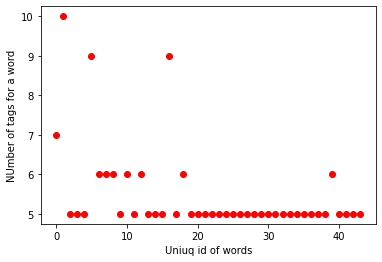

******Fold 2************

 Average Values 

Precision: 0.9587 Recall: 0.9602 F1: 0.9564

 Statistics 

NUmber of words in Training set: 32677
NUmber of tags in Training set: 369
Min,max and average length of sentences : 1 167 21


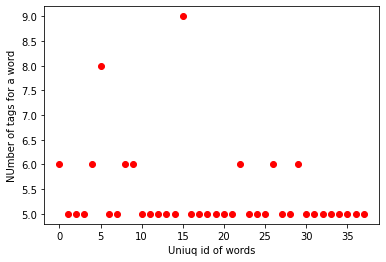

******Fold 3************

 Average Values 

Precision: 0.9569 Recall: 0.9589 F1: 0.9549

 Statistics 

NUmber of words in Training set: 32746
NUmber of tags in Training set: 369
Min,max and average length of sentences : 1 195 21


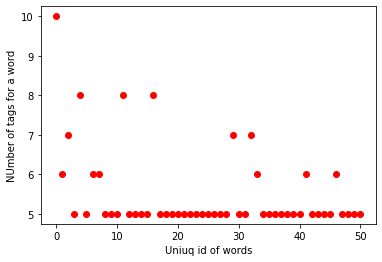

In [36]:
TagSet.add("^")
V=len(Vocab)
T=len(TagSet)

from sklearn.model_selection import KFold
kf = KFold(n_splits=3,shuffle=True)
ThreeFold=kf.split(Sentences)
AverageDict={}
fold=1
for i in ThreeFold:
    n=0
    d=0
    TestTagSet=set()
    Train1,Test1=i[0],i[1]
    TrainSet=[]
    TestSet=[]
    for i in Train1:
        TrainSet.append(Sentences[i])
    for i in Test1:
        TestSet.append(Sentences[i])
    EmissionCount,CountWordsOfTag=EmissionProbability(TrainSet)
    TagPairCount=TransitionProbability(TrainSet)
    if(select!=1):
      TagTripletCount=TrigramsCount(TrainSet)    
    EProbab={}
    TProbab={}
    for tag in TagSet:
        for word in Vocab:
            if tag in CountWordsOfTag:
                if(word+"_"+tag in EmissionCount):
                    EProbab[word+"_"+tag]=(EmissionCount[word+"_"+tag]+1)/(CountWordsOfTag[tag]+V)
                else:
                    EProbab[word+"_"+tag]=1/(CountWordsOfTag[tag]+V)
            else:
                EProbab[word+"_"+tag]=1/V
    for tag1 in TagSet:
        for tag2 in TagSet:
            if(tag1 in CountWordsOfTag):
                if(tag1+"_"+tag2 in TagPairCount):
                    TProbab[tag1+"_"+tag2]=(TagPairCount[tag1+"_"+tag2]+1)/(CountWordsOfTag[tag1]+T)
                else:
                    TProbab[tag1+"_"+tag2]=(1)/(CountWordsOfTag[tag1]+T)
            else:
                TProbab[tag1+"_"+tag2]=1/T
    TestSentence=[]
    TestTagSeq=[]
    ConfusionMatrix=[]
    for i in range(len(TagIndexMapping)):
        templis=[]
        for j in range(len(TagIndexMapping)):
            templis.append(0)
        ConfusionMatrix.append(templis)
    for Sentence in TestSet:
        TempSentlist=[]
        TempSeqList=[]
        for pair in Sentence:
    # error checking
            if(len(pair)==2):
                    TempSentlist.append(pair[0])
                    TempSeqList.append(pair[1])
        TestSentence.append(TempSentlist)
        TestTagSeq.append(TempSeqList)
    for i in range(len(TestSentence)):
    #     try:
        if(select==1):
            lis=Viterbi4(TestSentence[i])
        else:
            lis=TrigramsViterbi(TestSentence[i])

        for j in range(len(lis)):
            TestTagSet.add(TestTagSeq[i][j])
            TestTagSet.add(lis[j])
            if(lis[j]==TestTagSeq[i][j]):
    #             print(lis[j],TestTagSeq[i][j])
                n+=1
                ConfusionMatrix[TagIndexMapping[lis[j]]][TagIndexMapping[lis[j]]]+=1
            else:
                ConfusionMatrix[TagIndexMapping[TestTagSeq[i][j]]][TagIndexMapping[lis[j]]]+=1
            d+=1
#     print(ConfusionMatrix)
#     print(n/d)
# print(ConfusionMatrix)
    Recall={}
    Precision={}
    F1={}
    CountActual={}
    for i in TagSet:    
        if("^"!=i):
            temptotal=0
            for num in ConfusionMatrix[TagIndexMapping[i]]:
                temptotal+=num
            if(temptotal==0):
                Recall[i]=0
            else:
                Recall[i]=ConfusionMatrix[TagIndexMapping[i]][TagIndexMapping[i]]/temptotal
            CountActual[i]=temptotal
    for i in TagSet:
        if("^"!=i):
            temptotal=0
            for row in ConfusionMatrix:
                temptotal+=row[TagIndexMapping[i]]
            if(temptotal==0):
                Precision[i]=0
            else:
                Precision[i]=ConfusionMatrix[TagIndexMapping[i]][TagIndexMapping[i]]/temptotal
    for i in Precision:
        if(Precision[i]==0 and Recall[i]==0):
            F1[i]=0
        else:
            F1[i]=(2*Precision[i]*Recall[i])/(Precision[i]+Recall[i])
    TotalTags=0
    for i in CountActual:
        TotalTags+=CountActual[i]
    sum1=0
    sum2=0
    sum3=0
    if(fold==1):
        print("******Fold 1************")
        f=open("Confusion"+str(fold)+".csv",'w')
        f2=open("PRF"+str(fold),'w')
        fold+=1
    elif(fold==2):
        print("******Fold 2************")
        f=open("Confusion"+str(fold)+".csv",'w')
        f2=open("PRF"+str(fold),'w')
        fold+=1
    else:
        print("******Fold 3************")

        f=open("Confusion"+str(fold)+".csv",'w')
        f2=open("PRF"+str(fold),'w')
        fold+=1
    print("\n Average Values \n")
    for i in Precision:
    #     print(i,"        ",Precision[i],Recall[i])
        sum1+=(Precision[i]*CountActual[i])
        sum2+=(Recall[i]*CountActual[i])
        sum3+=(F1[i]*CountActual[i])
    print("Precision:",round(sum1/(TotalTags),4),"Recall:",round(sum2/(TotalTags),4),"F1:",round(sum3/TotalTags,4))
    prf=""
    for i in Precision:
        prf+=str(i)+"  Precision:"+str(round(Precision[i],4))+"  Recall:"+str(round(Recall[i],4))+"  F1:"+str(round(F1[i],4))+"\n"
    f2.write(prf)
    f2.close()
    writematrix=" "
    for i in IndexTagMapping:
        writematrix+=","+i[1].replace(",","comma")
    writematrix+="\n"
    for i in range(len(ConfusionMatrix)):
        if( "," in IndexTagMapping[i][1]):
            writematrix+=IndexTagMapping[i][1].replace(",","comma")
        else:
            writematrix+=IndexTagMapping[i][1]
        for j in ConfusionMatrix[i]:
            writematrix+=","+str(j)
        writematrix+="\n"
    f.write(writematrix)
    f.close()
    AverageDict[fold-1]=[Precision,Recall,F1,round(sum1/(TotalTags),4),round(sum2/(TotalTags),4),round(sum3/TotalTags,4)]
    print("\n Statistics \n")
    stat(TestSet,fold-1)

In [ ]:
print(len(TProbab))

223729


In [39]:
AvgPrecision={}
AvgRecall={}
AvgF1={}
for i in TagSet:
    if(i!="^"):
        AvgPrecision[i]=(AverageDict[1][0][i]+AverageDict[2][0][i]+AverageDict[3][0][i])/3
        AvgRecall[i]=(AverageDict[1][1][i]+AverageDict[2][1][i]+AverageDict[3][1][i])/3
        AvgF1[i]=(AverageDict[1][2][i]+AverageDict[2][2][i]+AverageDict[3][2][i])/3
f2=open("AvgPRF",'w')
prf=""
for i in Precision:
    prf+=str(i)+"  Precision:"+str(round(AvgPrecision[i],4))+"  Recall:"+str(round(AvgRecall[i],4))+"  F1:"+str(round(AvgF1[i],4))+"\n"
f2.write(prf)
f2.close()
print("Average Scores for 3 folds:")
print("Precision:" ,round((AverageDict[1][3]+AverageDict[2][3]+AverageDict[3][3])/3,4) )
print("Recall:" ,round((AverageDict[1][4]+AverageDict[2][4]+AverageDict[3][4])/3,4) )
print("F1:" ,(AverageDict[1][5]+AverageDict[2][5]+AverageDict[3][5])/3 )


min1=1
val=""

for i in Precision:
    if(Precision[i]==0 ):
        print(i)
        min1=Precision[i]
        val=i
print(min1,val)


Average Scores for 3 folds:
Precision: 0.9577
Recall: 0.9594
F1: 0.9554666666666667
OD-HL
FW-PP$-TL
DO-NC
BE-TL
PPSS-TL
HVZ-NC
DTS-HL
PPO-HL
CC-NC
PPS+BEZ-HL
BED-NC
WDT+BEZ-TL
FW-OD-NC
FW-PP$
FW-RB+CC
FW-CD
NP-NC
VBN-TL-NC
BEM*
QL-TL
QL-NC
PPSS+HV-TL
PN-HL
NR-NC
BER-TL
NN-TL-NC
(-HL
HV-NC
PPSS+BEZ*
.-TL
NPS-HL
RBR-NC
CS-HL
FW-TO+VB
CC-HL
DTI-TL
WRB+BEZ-TL
OD-NC
JJR-NC
DT-TL
BEZ-HL
FW-UH-NC
PPSS+BER-NC
BEZ-NC
PPSS+BEZ
*-HL
DOZ-TL
NP+HVZ-NC
DT+BEZ-NC
WPS-NC
WRB-TL
HVG-HL
WRB+IN
WQL-TL
BEDZ-NC
CD$
,-HL
FW-IN+NP-TL
FW-*
DO-HL
UH-TL
FW-VB-TL
FW-NPS-TL
FW-WPO
NNS$-NC
MD-TL
ABN-HL
BER-HL
WDT+BER
BE-HL
VB+RP
EX+MD
FW-*-TL
CD-TL-HL
PPL-NC
NP-TL-HL
FW-NPS
FW-NN-TL-NC
VBN-TL-HL
FW-PN
WQL
---HL
RBR+CS
PPS-NC
FW-AT-HL
CS-NC
PN-TL
WDT+HVZ
JJ$-TL
DOZ*-TL
FW-NNS-NC
DO+PPSS
VB-NC
CS-TL
FW-JJ-NC
PN+HVZ
PN+HVD
DT$
PPSS+BER-TL
:-HL
FW-VBG-TL
FW-UH-TL
WPS-TL
WDT+BER+PP
HVD-HL
HV-HL
,-TL
FW-IN+AT-T
FW-NN$-TL
RB+BEZ-NC
DOZ-HL
DT-NC
EX-NC
DTI-HL
PP$-NC
PPSS+BER-N
DOD*-TL
RB-NC
UH-NC
PPL-HL
ABN-TL
PPS-TL
PPS+B